In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
import optuna
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import auc, make_scorer, f1_score
from sklearn.metrics import precision_recall_curve
import plotly
import shap


from optuna.visualization import plot_contour
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances

import pickle
#oversampling
warnings.filterwarnings('ignore')
%matplotlib inline


In [11]:
# Class for model training, evaluation and tuining
class Model:
    x_train, y_train, x_test, y_test = None, None, None, None
    model = RandomForestClassifier()
    alternative_model = SVC(probability=True)
    tuned_model = None
    classes = ['Below 10%','Over 10%']
    # best model params
    optuna_study = None
    
    def __init__(self,X_file,Y_file):
        self.X = pd.read_csv(X_file)
        self.Y = pd.read_csv(Y_file)
        self.X = self.X.values
        self.Y = self.Y.values
        self.Y = self.Y.reshape(-1)
           
    # split training and test data
    def data_split(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.Y, test_size=0.20, random_state=9, shuffle=True)

    def train_model(self):
        self.model.fit(self.x_train,self.y_train)
        return self

    @staticmethod
    def model_metrics(y_true, y_pred):
        print("--------------------------------")
        print("\nModel Evaluation:")
        print("accurancy: ",metrics.accuracy_score(y_true,y_pred))
        print("precision: ",metrics.precision_score(y_true,y_pred,average='macro'))
        print("recall: ",metrics.recall_score(y_true,y_pred,average='micro'))
        print("f-measure: ",metrics.f1_score(y_true,y_pred,average='weighted'))
        print("--------------------------------")

    @staticmethod
    def plot_conf_matrix(classes, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.xticks(np.arange(len(classes)) + 0.5, classes)
        plt.yticks(np.arange(len(classes)) + 0.5, classes, rotation=0)
        plt.show()
    
    @staticmethod
    def plot_roc_curve(y_probab, y_true):
        probabilities = y_probab
        # Compute ROC curve and ROC AUC for each class
        n_classes = probabilities.shape[1]
        roc_auc = []
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true, probabilities[:, i], pos_label=i)
            roc_auc.append(auc(fpr, tpr))
        # Compute average ROC AUC score
        average_roc_auc = sum(roc_auc) / n_classes
        # Print ROC AUC score for each class
        for i, auc_score in enumerate(roc_auc):
            print(f"Class {i} ROC AUC: {auc_score}")
        # Print average ROC AUC score
        print("Average ROC AUC:", average_roc_auc)
        # Plot ROC curve for each class
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true, probabilities[:, i], pos_label=i)
            plt.plot(fpr, tpr, label=f'Class {i} (ROC AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Each Class')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    
    @staticmethod
    def plot_precission_recal_curve(y_probab,y_pred,y_true):
        # predict probabilities
        lr_probs = y_probab
        # keep probabilities for the positive outcome only
        lr_probs = lr_probs[:, 1]
        # predict class values
        yhat = y_pred
        precision, recall, _ = precision_recall_curve(y_true, lr_probs)
        # plot the precision-recall curves
        no_skill = len(y_true[y_true==1]) / len(y_true)
        plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        plt.plot(recall, precision, marker='.', label='Model')
        # axis labels
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        # show the legend
        plt.legend()
        # show the plot
        plt.show()
    
    # below code is pulled from sklearn documentation
    @staticmethod
    def plot_learning_curve(
        estimator,
        X,
        y,
        ylim=None,
        n_jobs=None,
        scoring=None,
        train_sizes=np.linspace(0.1, 1.0, 5),
    ):
        _, axes = plt.subplots(3, 1, figsize=(10, 15))
        cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
        title = 'learning curve'

        """
        Generate 3 plots: the test and training learning curve, the training
        samples vs fit times curve, the fit times vs score curve.

        Parameters
        ----------
        estimator : estimator instance
            An estimator instance implementing `fit` and `predict` methods which
            will be cloned for each validation.

        title : str
            Title for the chart.

        X : array-like of shape (n_samples, n_features)
            Training vector, where ``n_samples`` is the number of samples and
            ``n_features`` is the number of features.

        y : array-like of shape (n_samples) or (n_samples, n_features)
            Target relative to ``X`` for classification or regression;
            None for unsupervised learning.

        axes : array-like of shape (3,), default=None
            Axes to use for plotting the curves.

        ylim : tuple of shape (2,), default=None
            Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

        cv : int, cross-validation generator or an iterable, default=None
            Determines the cross-validation splitting strategy.
            Possible inputs for cv are:

            - None, to use the default 5-fold cross-validation,
            - integer, to specify the number of folds.
            - :term:`CV splitter`,
            - An iterable yielding (train, test) splits as arrays of indices.

            For integer/None inputs, if ``y`` is binary or multiclass,
            :class:`StratifiedKFold` used. If the estimator is not a classifier
            or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

            Refer :ref:`User Guide <cross_validation>` for the various
            cross-validators that can be used here.

        n_jobs : int or None, default=None
            Number of jobs to run in parallel.
            ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
            ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
            for more details.

        scoring : str or callable, default=None
            A str (see model evaluation documentation) or
            a scorer callable object / function with signature
            ``scorer(estimator, X, y)``.

        train_sizes : array-like of shape (n_ticks,)
            Relative or absolute numbers of training examples that will be used to
            generate the learning curve. If the ``dtype`` is float, it is regarded
            as a fraction of the maximum size of the training set (that is
            determined by the selected validation method), i.e. it has to be within
            (0, 1]. Otherwise it is interpreted as absolute sizes of the training
            sets. Note that for classification the number of samples usually have
            to be big enough to contain at least one sample from each class.
            (default: np.linspace(0.1, 1.0, 5))
        """
        if axes is None:
            _, axes = plt.subplots(1, 3, figsize=(20, 5))

        axes[0].set_title(title)
        if ylim is not None:
            axes[0].set_ylim(*ylim)
        axes[0].set_xlabel("Training examples")
        axes[0].set_ylabel("Score")

        train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
            estimator,
            X,
            y,
            scoring=scoring,
            cv=cv,
            n_jobs=n_jobs,
            train_sizes=train_sizes,
            return_times=True,
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        fit_times_mean = np.mean(fit_times, axis=1)
        fit_times_std = np.std(fit_times, axis=1)

        # Plot learning curve
        axes[0].grid()
        axes[0].fill_between(
            train_sizes,
            train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std,
            alpha=0.1,
            color="r",
        )
        axes[0].fill_between(
            train_sizes,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.1,
            color="g",
        )
        axes[0].plot(
            train_sizes, train_scores_mean, "o-", color="r", label="Training score"
        )
        axes[0].plot(
            train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
        )
        axes[0].legend(loc="best")

        # Plot n_samples vs fit_times
        axes[1].grid()
        axes[1].plot(train_sizes, fit_times_mean, "o-")
        axes[1].fill_between(
            train_sizes,
            fit_times_mean - fit_times_std,
            fit_times_mean + fit_times_std,
            alpha=0.1,
        )
        axes[1].set_xlabel("Training examples")
        axes[1].set_ylabel("fit_times")
        axes[1].set_title("Scalability of the model")

        # Plot fit_time vs score
        fit_time_argsort = fit_times_mean.argsort()
        fit_time_sorted = fit_times_mean[fit_time_argsort]
        test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
        test_scores_std_sorted = test_scores_std[fit_time_argsort]
        axes[2].grid()
        axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
        axes[2].fill_between(
            fit_time_sorted,
            test_scores_mean_sorted - test_scores_std_sorted,
            test_scores_mean_sorted + test_scores_std_sorted,
            alpha=0.1,
        )
        axes[2].set_xlabel("fit_times")
        axes[2].set_ylabel("Score")
        axes[2].set_title("Performance of the model")

        plt.show()
    
    # model evaluation function (calls all evaluation methods)
    def evaluate_model(self,tuned=False,alternative=False):
            if tuned:
                model = self.tuned_model
            elif alternative:
                model = self.alternative_model
            else:
                model = self.model
            result = cross_val_score(model, self.x_train, self.y_train, cv=6, scoring='accuracy')
            print("Cross validatation Accuracy: ", np.mean(result))
            y_pred = model.predict(self.x_test)
            print(classification_report(self.y_test, y_pred,target_names=self.classes))
            y_pred_probab = model.predict_proba(self.x_test)
            self.model_metrics(self.y_test,y_pred)
            self.plot_conf_matrix(self.classes,self.y_test,y_pred)
            self.plot_roc_curve(y_pred_probab,self.y_test)
            self.plot_learning_curve(model,self.x_train,self.y_train,ylim = (0.0,1.1),n_jobs=4,scoring="accuracy")
            self.plot_precission_recal_curve(y_pred_probab,y_pred,self.y_test)
            return self

    # tune model with sk-learn grid search
    def grid_search_tuning(self):
        # Define the model
        model = self.alternative_model

        params = {
                'C': [0.1, 1, 10, 100],  # Regularization parameter
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
                'gamma': ['scale', 'auto'],  # Kernel coefficient
                'degree': [2, 3, 4],  # Degree of the polynomial kernel function
                'coef0': [0.0, 1.0],  # Independent term in kernel function
                }

        # Define the cross-validation strategy
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=44)

        # Perform GridSearchCV
        scoring = make_scorer(f1_score, average='weighted')
        search = GridSearchCV(model, params, scoring=scoring, n_jobs=4, cv=cv, verbose=2)
        result = search.fit(self.x_train, self.y_train)

        # Print the results
        print('Best Score: %s' % result.best_score_)
        print('Best Hyperparameters: %s' % result.best_params_)
        # save tuned random forest model
        self.alternative_model = result.best_estimator_
        return self

    @staticmethod
    # search space
    def objective(trial, self):
        
        params = {
            'n_estimators': trial.suggest_categorical('n_estimators', [50, 100, 200]),
            'max_depth': trial.suggest_categorical('max_depth', [10, 20]),
            'min_samples_split': trial.suggest_categorical('min_samples_split', [2, 5, 10]),
            'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [1, 2, 4]),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'max_leaf_nodes': trial.suggest_categorical('max_leaf_nodes', [10, 20]),
            'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.5),
            'class_weight': trial.suggest_categorical('class_weight', ['balanced']),
            'random_state': 42
        }
        
        rf_clf = RandomForestClassifier(**params)
        score = cross_val_score(rf_clf, self.x_train, self.y_train, cv=5, scoring='f1_weighted').mean()
        return score
    
    # fine tuning using optuna
    def fine_tune_model(self):
        # create optuna study
        study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
        # try 100 different parameter combinations
        study.optimize(lambda trial: self.objective(trial, self), n_trials=500)
        self.optuna_study = study
        best_trial = study.best_trial
        best_score = study.best_value
        print("Best params:")
        for key, value in best_trial.params.items():
            print("{}: {}".format(key, value))
        print("Best Score:", best_score)
        # train model with best params
        self.tuned_model = RandomForestClassifier(**best_trial.params)
        self.tuned_model.fit(self.x_train,self.y_train)
        return self
    
    # plot parameter exploration
    def plot_tuning(self):
        plot_optimization_history(self.optuna_study)
        plot_parallel_coordinate(self.optuna_study)
        plot_param_importances(self.optuna_study)
        plot_contour(self.optuna_study, params=['n_estimators', 'max_depth'])

    def plot_shap(self):
        # Compute SHAP values
        explainer = shap.Explainer(self.tuned_model)
        shap_values = explainer(self.x_train)
        # Plot SHAP values
        shap.summary_plot(shap_values, self.x_train)
    
    # export model
    def save_model(self):
        pickle.dump(self.tuned_model, open('model.sav', 'wb'))

    # export training and testing data
    def export_dataset(self):
        np.savetxt("x_train.csv", self.x_train, delimiter=',')
        np.savetxt("y_train.csv", self.y_train, delimiter=',')
        np.savetxt("x_test.csv", self.x_test, delimiter=',')
        np.savetxt("y_test.csv", self.y_test, delimiter=',')

In [12]:
tests = Model('X.csv','Y.csv')
tests.data_split()
tests.export_dataset()

In [13]:
tests.train_model()

Cross validatation Accuracy:  0.58764017140443
              precision    recall  f1-score   support

   Below 10%       0.60      0.65      0.62       423
    Over 10%       0.55      0.49      0.52       366

    accuracy                           0.58       789
   macro avg       0.57      0.57      0.57       789
weighted avg       0.57      0.58      0.57       789

--------------------------------

Model Evaluation:
accurancy:  0.5754119138149556
precision:  0.5713823179595612
recall:  0.5754119138149556
f-measure:  0.5730056021668762
--------------------------------


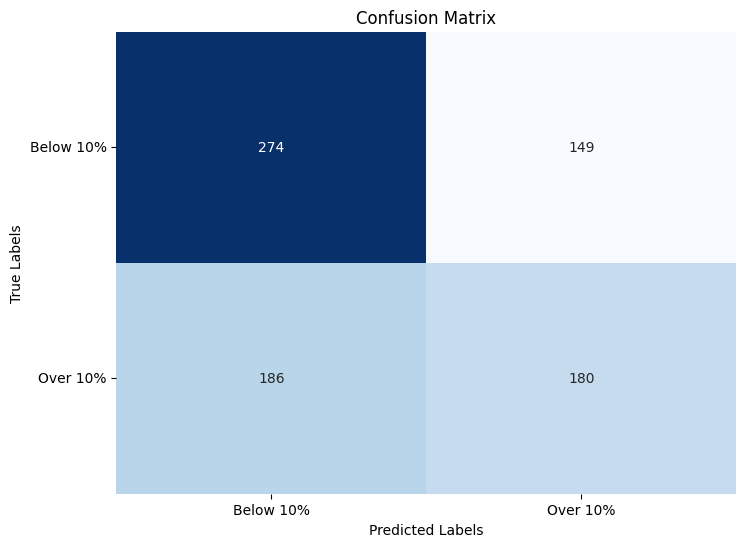

Class 0 ROC AUC: 0.5934225994393417
Class 1 ROC AUC: 0.593422599439342
Average ROC AUC: 0.5934225994393418


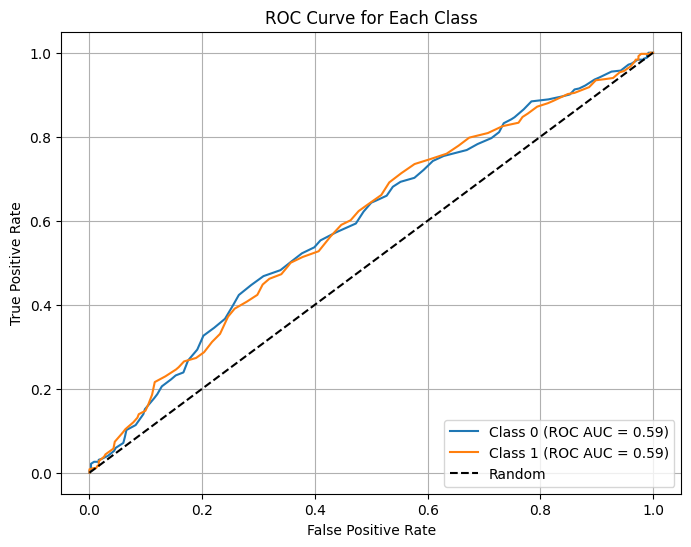

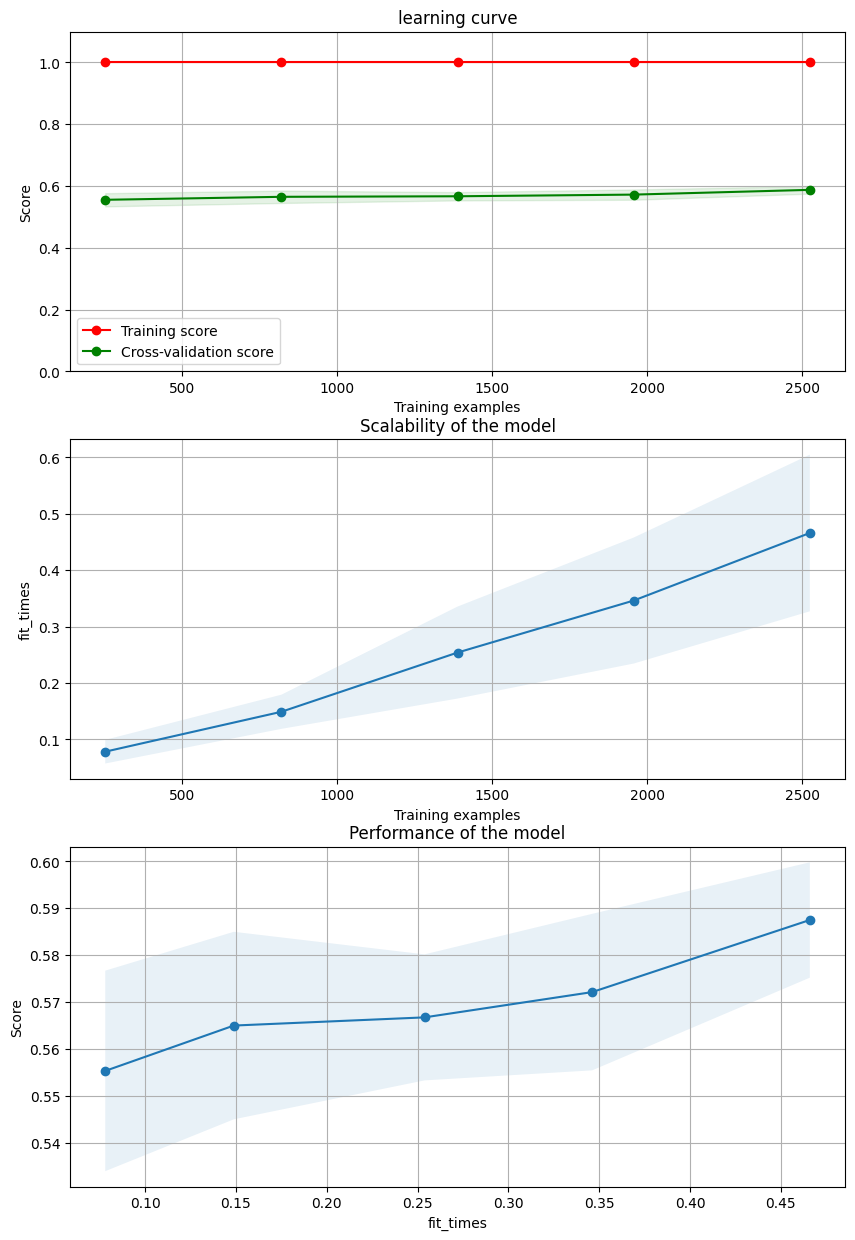

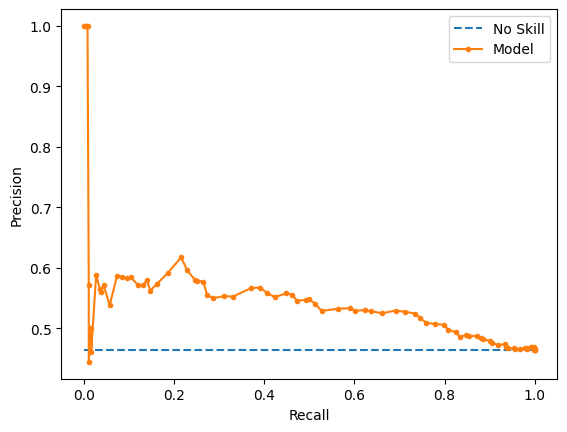

In [14]:
tests.evaluate_model()

In [27]:
tests.grid_search_tuning()

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END C=0.1, coef0=0.0, degree=2, gamma=scale, kernel=linear; total time=   0.3s
[CV] END C=0.1, coef0=0.0, degree=2, gamma=scale, kernel=linear; total time=   0.4s
[CV] END C=0.1, coef0=0.0, degree=2, gamma=scale, kernel=linear; total time=   0.4s
[CV] END C=0.1, coef0=0.0, degree=2, gamma=scale, kernel=linear; total time=   0.7s
[CV] END C=0.1, coef0=0.0, degree=2, gamma=scale, kernel=linear; total time=   0.9s
[CV] END C=0.1, coef0=0.0, degree=2, gamma=scale, kernel=poly; total time=   1.2s
[CV] END C=0.1, coef0=0.0, degree=2, gamma=scale, kernel=poly; total time=   1.3s
[CV] END C=0.1, coef0=0.0, degree=2, gamma=scale, kernel=poly; total time=   1.2s
[CV] END C=0.1, coef0=0.0, degree=2, gamma=scale, kernel=poly; total time=   0.8s
[CV] END C=0.1, coef0=0.0, degree=2, gamma=scale, kernel=poly; total time=   0.6s
[CV] END C=0.1, coef0=0.0, degree=2, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END C=0.1, coef0=0.0,

In [15]:
tests.fine_tune_model()

[I 2024-02-18 02:01:10,474] A new study created in memory with name: no-name-c49f1a17-1247-4323-822b-bb20062f9077
[I 2024-02-18 02:01:10,960] Trial 0 finished with value: 0.3106915691744224 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt', 'max_leaf_nodes': 20, 'min_impurity_decrease': 0.16214277593305787, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.3106915691744224.
[I 2024-02-18 02:01:11,363] Trial 1 finished with value: 0.3740543372223676 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.4309982504468583, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.3740543372223676.
[I 2024-02-18 02:01:12,049] Trial 2 finished with value: 0.3106915691744224 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5

Best params:
n_estimators: 100
max_depth: 20
min_samples_split: 5
min_samples_leaf: 4
bootstrap: True
max_features: log2
max_leaf_nodes: 20
min_impurity_decrease: 0.0004209089091486704
class_weight: balanced
Best Score: 0.5981983460208287


In [23]:
plot_optimization_history(tests.optuna_study)

In [24]:
plot_parallel_coordinate(tests.optuna_study) 

In [25]:
plot_param_importances(tests.optuna_study)

In [26]:
plot_contour(tests.optuna_study, params=['min_impurity_decrease', 'bootstrap'])

Cross validatation Accuracy:  0.5993674935119803
              precision    recall  f1-score   support

   Below 10%       0.64      0.52      0.57       423
    Over 10%       0.54      0.66      0.59       366

    accuracy                           0.58       789
   macro avg       0.59      0.59      0.58       789
weighted avg       0.59      0.58      0.58       789

--------------------------------

Model Evaluation:
accurancy:  0.5842839036755386
precision:  0.5899370167042653
recall:  0.5842839036755386
f-measure:  0.5833190489065201
--------------------------------


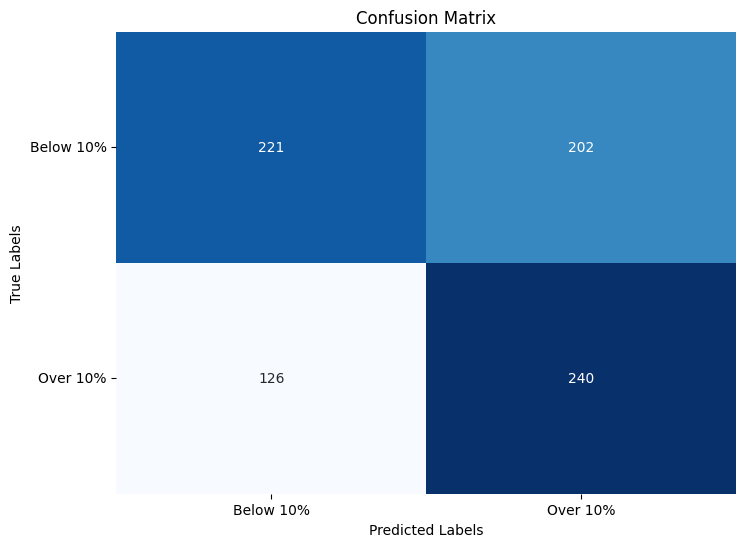

Class 0 ROC AUC: 0.6042514436305856
Class 1 ROC AUC: 0.6042514436305857
Average ROC AUC: 0.6042514436305857


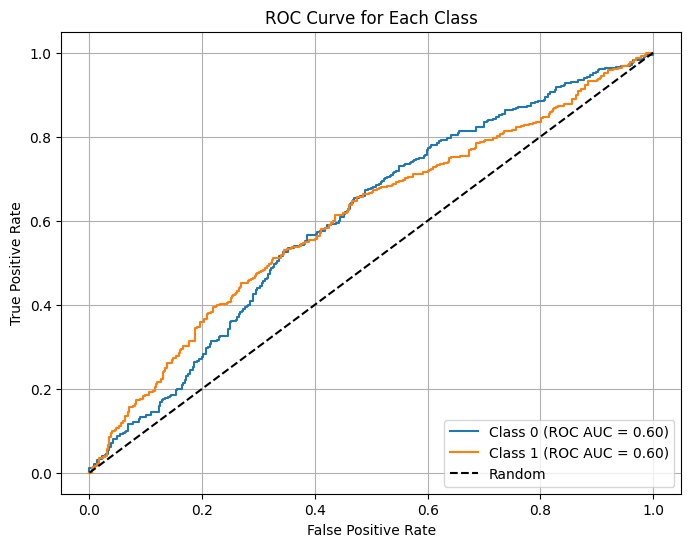

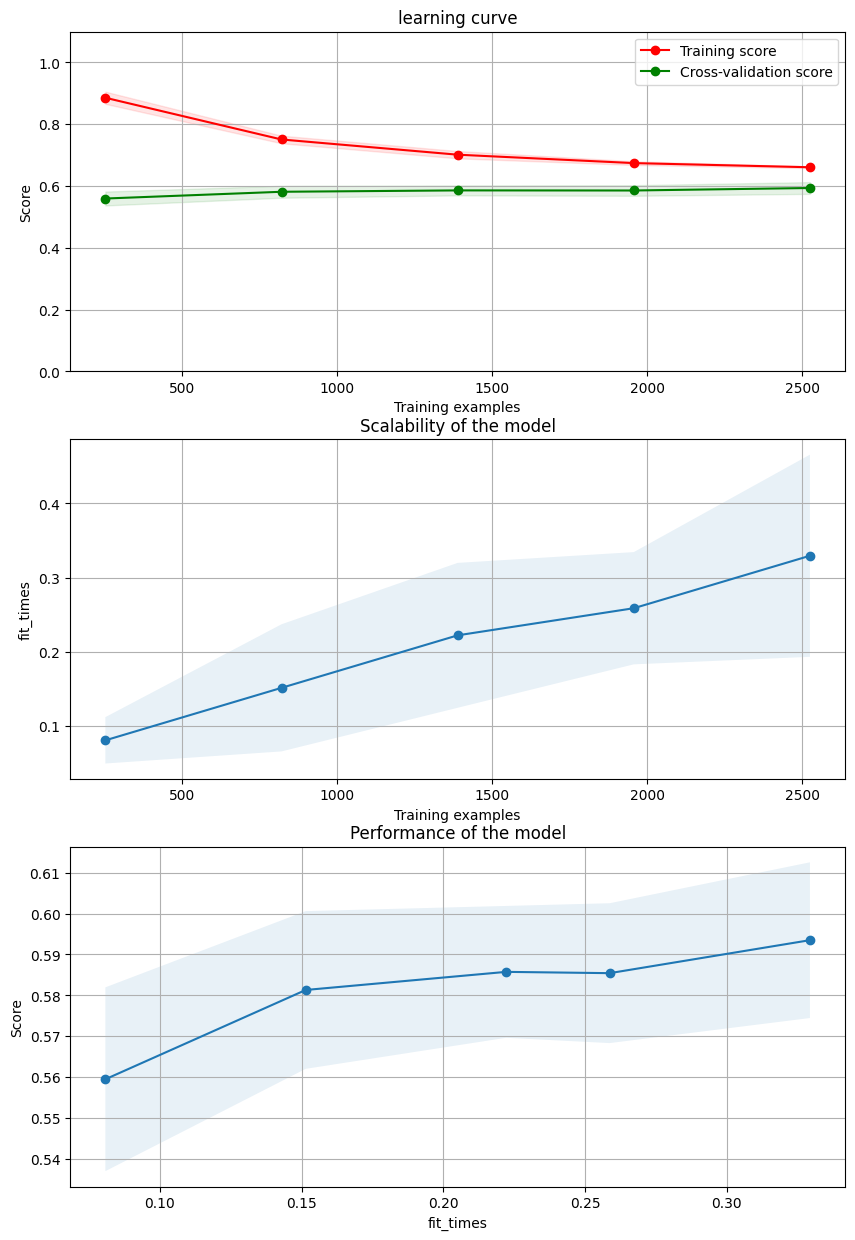

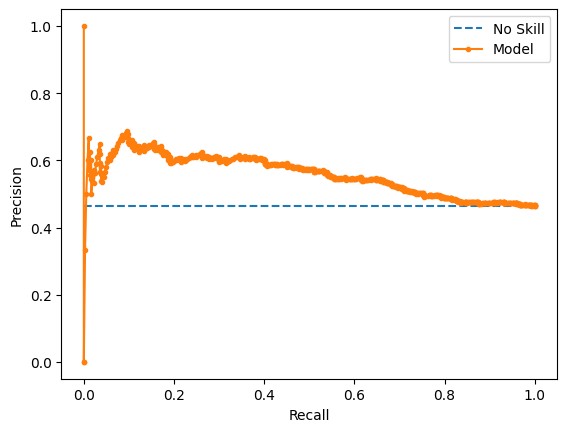

In [16]:
tests.evaluate_model(tuned=True)

Cross validatation Accuracy:  0.5676715553141408
              precision    recall  f1-score   support

   Below 10%       0.58      0.62      0.60       423
    Over 10%       0.52      0.49      0.51       366

    accuracy                           0.56       789
   macro avg       0.55      0.55      0.55       789
weighted avg       0.56      0.56      0.56       789

--------------------------------

Model Evaluation:
accurancy:  0.5576679340937896
precision:  0.5537579859656472
recall:  0.5576679340937896
f-measure:  0.5561954021796885
--------------------------------


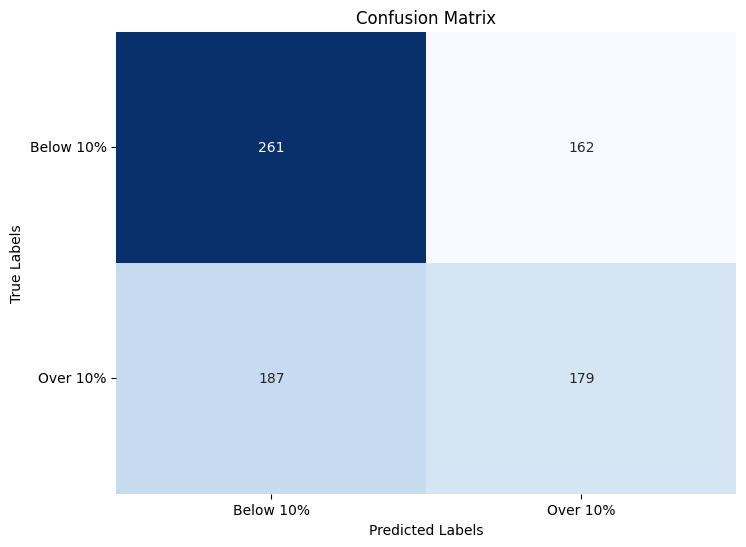

Class 0 ROC AUC: 0.5544865584105207
Class 1 ROC AUC: 0.5544865584105207
Average ROC AUC: 0.5544865584105207


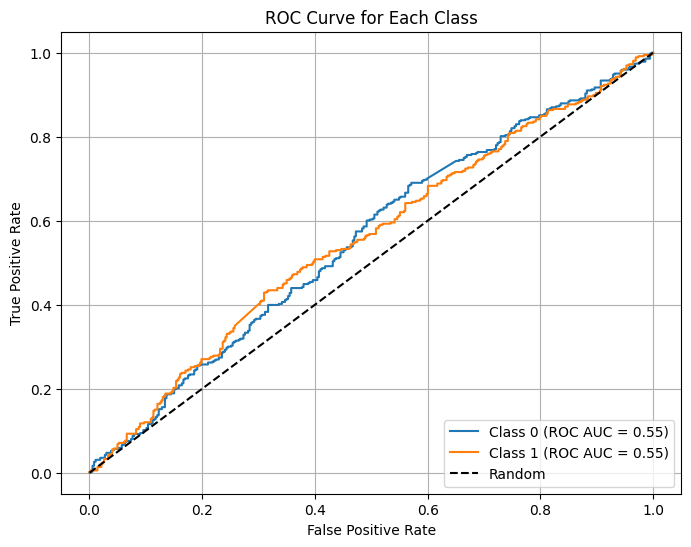

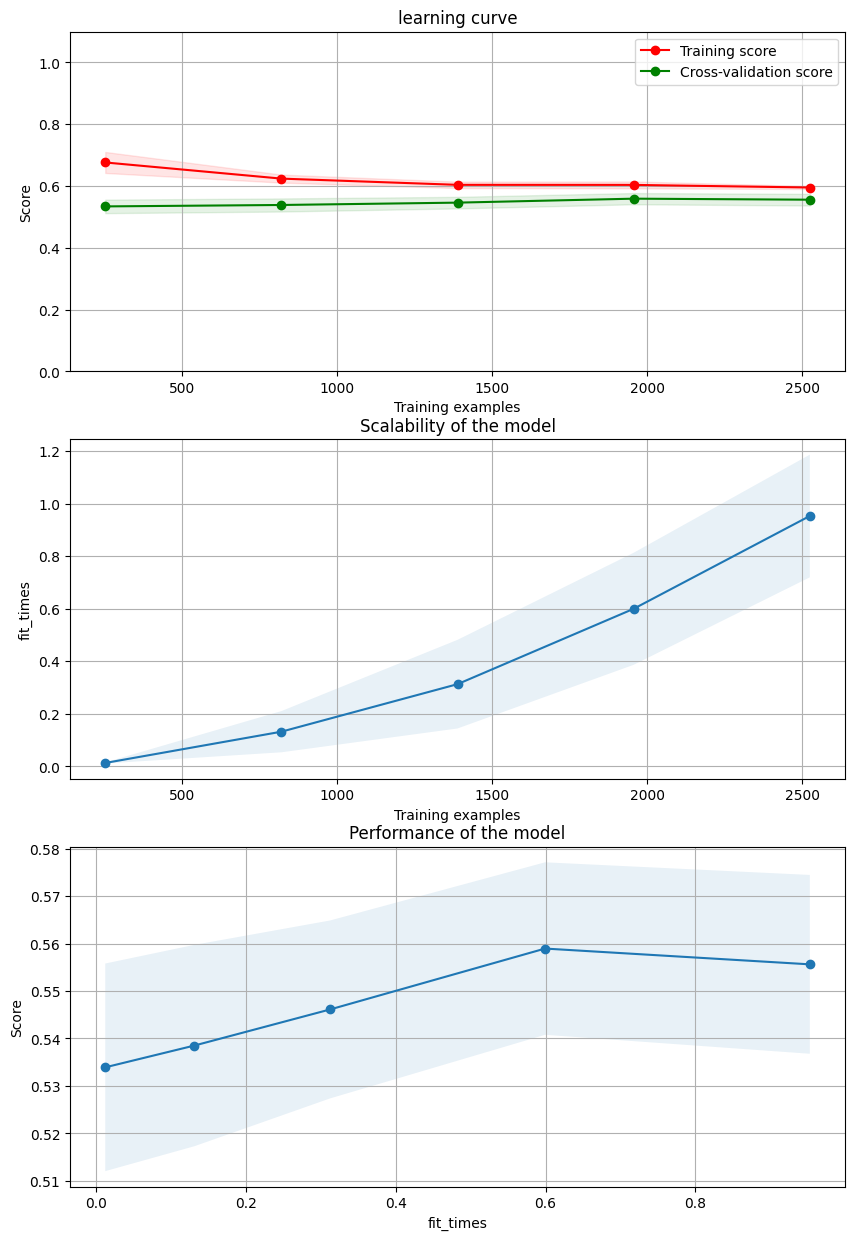

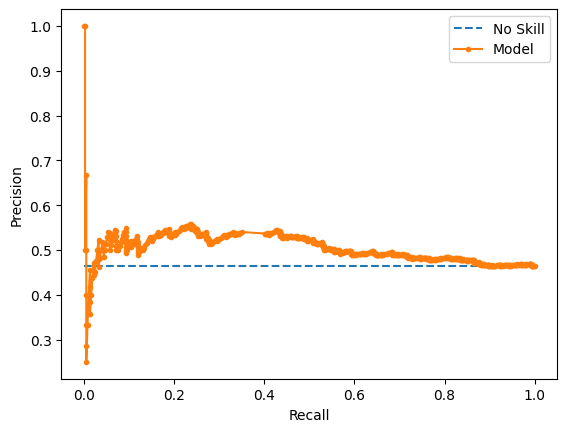

In [28]:
tests.evaluate_model(alternative=True)

In [21]:
tests.plot_tuning()

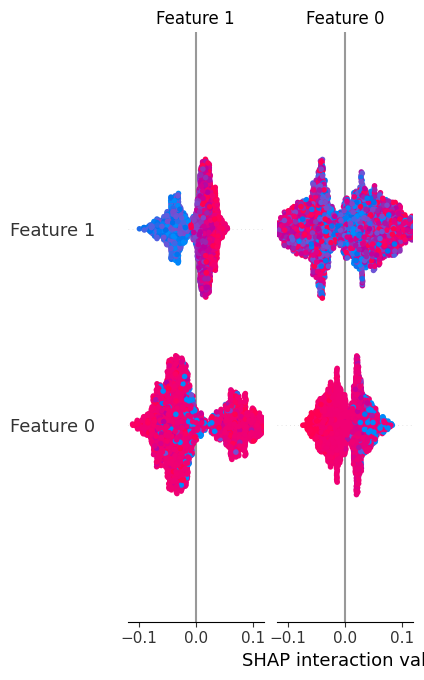

In [18]:
tests.plot_shap()

In [19]:
tests.save_model()